In [8]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [4]:
n=100000
x=np.arange(n)
y = np.random.normal(size=n)

<AxesSubplot:ylabel='Count'>

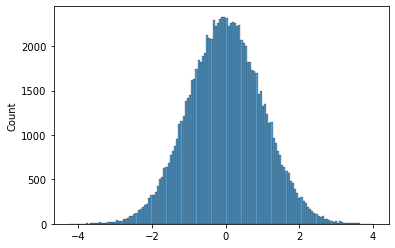

In [14]:
sns.histplot(y)

In [25]:
ymin=min(y)
ymax=max(y)
ymin,ymax

(-4.249123485462995, 4.010259714410684)

In [20]:
points=np.linspace(ymin,ymax,2000)

In [21]:
from scipy import stats

In [22]:
kernel = stats.gaussian_kde(y)

In [23]:
y2=kernel(points)

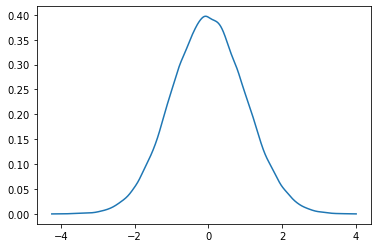

In [28]:
plt.plot(points,y2)